In [1]:
from Utils.preprocessing import *
from Utils.pipelineComponents import *
from Utils.preprocessing import *

import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')

RANDOM_STATE = 2024

# Webscraping Portion

In [2]:
# Read prof's sample data to view format & data science roles
sample_data_a = pd.read_csv("Data/jobs_in_data.csv")
sample_data_b = pd.read_csv("Data/QF632_Project_2_b.csv")
sample_data_c = pd.read_csv("Data/QF632_Project_2_c.csv")
sample_data_d = pd.read_csv("Data/Glassdoor_Salary_Cleaned_Version.csv")

In [10]:
base_url = "https://h1bdata.info/index.php?em=&job=data+scientist&city=&year=all+years"
roles = ["data scientist", "data analyst", "data storyteller", "data insights", "research scientist", "business data analyst",
        "data analytics", "data engineer", "machine learning", "ml engineer", "ai architect"]

all_df = pd.DataFrame()
for role in roles:
    job = "+".join(role.split(" "))
    url = base_url + "/index.php?em=&job=" + job + "&city=&year=all+years"
    try: 
        dfs_base = pd.read_html(url)
    except: 
        continue
    
    # to include all other variations, add a '&'
    url = base_url + "/index.php?em=&job=" + job + "+&&city=&year=all+years"
    
    try:
        dfs_var = pd.read_html(url)
    except:
        continue
    
    temp_df = pd.concat([dfs_base[0], dfs_var[0]])
    temp_df["TYPE"] = role
    
    all_df = pd.concat([all_df, temp_df])

print(all_df.shape)
all_df.sample(5)

(80866, 8)


,EMPLOYER,JOB TITLE,BASE SALARY,LOCATION,SUBMIT DATE,START DATE,Unnamed: 6,TYPE
2185,CHOCTAW NATION OF OKLAHOMA,DATA ENGINEER II,90000,"DURANT, OK",09/24/2020,10/05/2020,NaN,data engineer
186,BRASKEM AMERICA INC,"DATA SCIENTIST - DATA ANALYTICS , MACHINE LEAR...",67000,"PITTSBURGH, PA",03/06/2020,08/26/2020,NaN,data scientist
1973,3I INFOTECH INC,DATA ENGINEER,75000,"GRAPEVINE, TX",11/02/2017,11/13/2017,NaN,data engineer
2572,CROM TECHNOLOGY INC,DATA ANALYST,60000,"SOMERSET, NJ",03/19/2016,08/15/2016,NaN,data analyst
1650,ROBOTICS TECHNOLOGIES LLC,DATA ANALYST,48672,"DURANT, OK",12/01/2021,12/01/2021,NaN,data analyst


# Data Analysis

In [15]:
all_df["START DATE"] = pd.to_datetime(all_df["START DATE"], errors='coerce')
all_df["SUBMIT DATE"] = pd.to_datetime(all_df["SUBMIT DATE"], errors='coerce')
all_df = all_df.drop_duplicates()

# Remove all non-numeric "y" values
all_df2 = all_df[pd.to_numeric(all_df['BASE SALARY'], errors='coerce').notnull()].copy()

# all_df2 = all_df.dropna(subset = ["BASE SALARY"]).copy()
all_df2 = all_df2.drop(columns=["Unnamed: 6"]).reset_index(drop=True)
all_df2["YEAR"] = pd.DatetimeIndex(all_df2['START DATE']).year

# To get state, first remove all symbols, then take the last two letters
regex = re.compile('[^a-zA-Z]')
all_df2['STATE'] = all_df2.LOCATION.apply(lambda x:regex.sub('', x)[-2:])
all_df2 = all_df2.rename(columns={"BASE SALARY":"y"})
all_df2["y"] =  pd.to_numeric(all_df2["y"]) / 1000

print(all_df2.shape)
all_df2.sample(5)

(74810, 9)


,EMPLOYER,JOB TITLE,y,LOCATION,SUBMIT DATE,START DATE,TYPE,YEAR,STATE
33623,FIRST REPUBLIC BANK,DATA ANALYST,150.000,"SAN FRANCISCO, CA",2022-06-17,2022-07-18,data analyst,2022,CA
47387,RESEARCH FOUNDATION FOR MENTAL HYGIENE INC,RESEARCH SCIENTIST I,56.565,"ALBANY, NY",2019-02-20,2019-05-28,research scientist,2019,NY
21168,TWITTER INC,DATA SCIENTIST II,152.000,"SAN FRANCISCO, CA",2020-05-11,2020-10-01,data scientist,2020,CA
19220,FORUM BRANDS LLC,DATA SCIENTIST I,85.000,"NEW YORK, NY",2022-06-21,2022-10-01,data scientist,2022,NY
56622,ROBOTICS TECHNOLOGIES LLC,DATA ENGINEER,92.414,"EAST PEORIA, IL",2020-11-04,2020-11-09,data engineer,2020,IL


## Numerical Features

## Categorical features
- Not sure if there is a way to further categorize the data into bigger subgroups (i.e., segregating state to urban and rural areas)

## Job functions

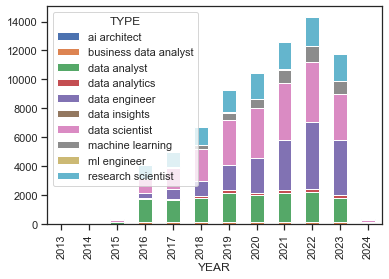

In [87]:
category = "TYPE"

df_plt = all_df2[["YEAR", category]].groupby(["YEAR", category], as_index = False).size().copy()
df_plt = df_plt.pivot(index='YEAR', columns=category, values='size')
ax = df_plt.plot.bar(stacked=True)

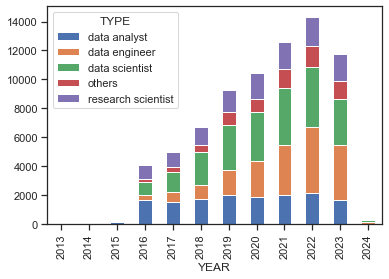

In [101]:
df3 = all_df2.copy()
core_cat = ["research scientist", "data scientist", "data analyst", "data engineer"]
df3['TYPE'].mask(~df3["TYPE"].isin(core_cat) ,'others', inplace=True)

df_plt = df3[["YEAR", category]].groupby(["YEAR", category], as_index = False).size().copy()
df_plt = df_plt.pivot(index='YEAR', columns=category, values='size')
ax = df_plt.plot.bar(stacked=True)

Those not of major classes can form 1 class called "others"

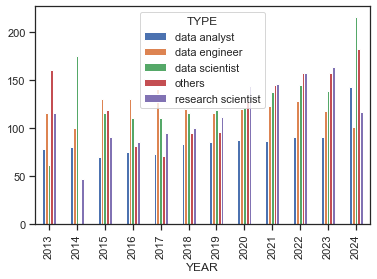

In [102]:
# get median wage of each job role for each year
df_plt = df3[["YEAR", category, "y"]].groupby(["YEAR", category], as_index = False).apply(lambda x:x.iloc[len(x)//2])
df_plt = df_plt.pivot(index='YEAR', columns=category, values='y')
ax = df_plt.plot.bar()

## State

In [103]:
category = "STATE"

df_plt = all_df2[["YEAR", category]].groupby(["YEAR", category], as_index = False).size().copy()
df_plt

,YEAR,STATE,size
0,2013,CA,1
1,2013,MA,2
2,2013,VA,1
3,2013,WA,3
4,2014,CA,5
...,...,...,...
472,2024,TX,33
473,2024,UT,1
474,2024,VA,13
475,2024,WA,73


In [76]:
df_plt = all_df2[["YEAR", "TYPE"]].groupby(["YEAR", "TYPE"], as_index = False).size().copy()
df_plt.pivot(index='YEAR', columns='TYPE', values='size')

TYPE,ai architect,business data analyst,data analyst,data analytics,data engineer,data insights,data scientist,machine learning,ml engineer,research scientist
YEAR,,,,,,,,,,
2013,NaN,NaN,1.0,NaN,2.0,NaN,1.0,1.0,NaN,2.0
2014,NaN,NaN,3.0,NaN,3.0,NaN,2.0,NaN,NaN,9.0
2015,NaN,8.0,92.0,12.0,45.0,1.0,75.0,6.0,NaN,93.0
2016,NaN,113.0,1616.0,47.0,365.0,10.0,938.0,41.0,NaN,946.0
2017,NaN,114.0,1538.0,94.0,662.0,14.0,1419.0,121.0,NaN,1029.0
2018,NaN,111.0,1689.0,108.0,1030.0,4.0,2264.0,258.0,1.0,1228.0
2019,1.0,136.0,2011.0,179.0,1719.0,7.0,3130.0,510.0,13.0,1540.0
2020,1.0,118.0,1847.0,141.0,2473.0,8.0,3442.0,619.0,17.0,1750.0
2021,1.0,135.0,1994.0,214.0,3464.0,19.0,3914.0,913.0,38.0,1876.0


In [54]:
categorical_features = ["EMPLOYER", "STATE", "TYPE", "YEAR"]

all_df2[["YEAR", 'EMPLOYER']].groupby(['EMPLOYER', 'YEAR']).size()

EMPLOYER        YEAR
0956588 BC LTD  2017    4
                2018    3
0965688 BC LTD  2018    1
                2019    5
                2020    1
                       ..
ZYWIE INC       2023    1
ZZZ'S INC       2019    1
[24]7AI INC     2020    1
                2021    1
â ISTACK LLC   2020    1
Length: 25320, dtype: int64

In [42]:
np.quantile(all_df2["EMPLOYER"].value_counts(), 0.5)

2.0

In [38]:
len(list(all_df2["EMPLOYER"].value_counts())) / 3

4377.333333333333

<AxesSubplot:>

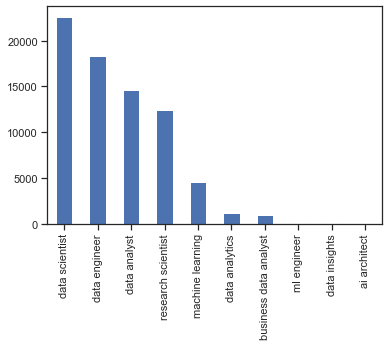

In [16]:
all_df2["TYPE"].value_counts().plot.bar()